# Reddit Post Classification Model

## **Purpose of NLP Task and Model**

On reddit, there is a subreddit called wallstreetbets where members talk about the status of the stock market and economy and what they are going to invest in. Many people come to the subreddit to learn about the stock market and economy. On the other hand, the subreddit is also filled with memes and other miscellaneous information. We wanted to find out if it is possible to build a recomendation system that can separate informative posts from uninformative posts. As a result we built a model that is able to classify a reddit post as informative or uninformative. 

## **Creating The Models**

L2-regularized logistic regression for binary or multiclass classification; trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals and prints out the strongest coefficients for each class.

In [60]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
from matplotlib import pyplot as plt

In [61]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            Y.append(label)

    return X, Y


In [63]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=10000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
        return self.log_reg.score(self.testX, self.testY)

    def predictions(self):
        return self.log_reg.predict(self.testX)
    
    def featureImportance(self, n=10, new_only = False):
        results = []
        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        weights=self.log_reg.coef_[0]
        for k in self.feature_vocab:
          reverse_vocab[self.feature_vocab[k]]=k
        if new_only:
          new_features = set(['econ_term_avg', 'presence_of_curse_words', "presence_of_links_pic", 'links', 'length_of_post', 'curse_words_avg', 'econ_term_counts', 'stats', 'years', 'stock_name', 'org'])
          for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))):
            if feature in new_features:
              results.append([feature, weight])
          return results        
          # binary
        if len(self.log_reg.classes_) == 2:
          weights=self.log_reg.coef_[0]

          cat=self.log_reg.classes_[1]
          for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
            results.append([feature, weight])
          print()

          cat=self.log_reg.classes_[0]
          for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
            results.append([feature, weight])
          print()

          # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):
            weights=self.log_reg.coef_[i]

            for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
              results.append([feature, weight])
            print()

        return results


        
    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [64]:
econ_terms = ['Required return', 'Indifference curve', 'Deflation', 'Short-termism', 'Exogenous', 'Null hypothesis', 'Patents', 'Tax incidence', 'Spot price', 'Outward investment', 'Crowding out', 'Velocity of circulation', 'Substitute goods', 'Relative income hypothesisv', 'Keynes, John Maynard', 'Smith, Adam', 'Inequality', 'Trust', 'Opportunity cost', 'Bonds', 'Economies of scale', 'Consumer surplus', 'European Union', 'Normal goods', 'Bankruptcy', 'National debt', 'J-curve', 'Neo-classical economics', 'Ricardian equivalence', 'Producer prices', 'Institutional economics', 'Boom and bust', 'Nationalisation', 'Transition economies', 'Output', 'Price discrimination', 'Equities', 'Real balance effect', 'Social benefits/costs', 'Quota', 'Big Mac index', 'Total return', 'Value added', 'Principal-agent theory', 'Euro Zone', 'Sustainable growth', 'Offshore', 'Tax burden', 'Property rights', 'Tax arbitrage', 'Shadow price', 'Brand', 'Efficiency', 'Profit margin', 'Deregulation', 'Altruism', 'Predatory pricing', 'Protectionism', 'OPEC', 'CAPM', 'Convergence', 'gni', 'Debt-equity ratio', 'Productivity', 'Tax competition', 'Growth', 'SDR', 'Discounted cashflow', 'Liquidity trap', 'Contagion', 'Satisficing', 'X-efficiency', 'Creative destruction', 'Consumer prices', 'Option', 'Profit', 'Hard currency', 'Factory prices', 'Savings', 'Returns', 'Regression analysis', 'Demographics', 'Expected returns', 'Paris Club', 'Probability', 'Monopoly', 'Transfers', 'Welfare economics', 'Visible trade', 'Mergers and acquisitions', 'Aid', 'Gini coefficient', 'Queueing', 'Usury', 'Assets', 'Underground economy', 'Liquidity', 'Wage drift', 'Financial markets', 'Windfall gains', 'Debt forgiveness', 'Government expenditure', 'Outsourcing', 'Appreciation', 'Nominal value', 'Advertising', 'Export credit', 'ILO', 'International trade', 'Globalisation', 'Percentile', 'Insurance', 'Peak pricing', 'Residual risk', 'Oligopoly', 'Systematic risk', 'Trade unions', 'Arbitrage', 'Bull', 'Imports', 'Stagnation', 'Budget', 'Capital asset pricing model', 'World Trade Organisation', 'Average', 'Consumption', 'Contestable market', 'Hypothecation', 'Structural unemployment', 'Uncertainty', 'Mean', 'Fixed costs', 'Speculative motive', 'Stability and Growth Pact', 'Competitiveness', 'Misery index', 'Services', 'Purchasing power parity', 'Ratings', 'G8', 'Positional goods', 'Gold', 'FDI', 'Vertical integrationj', 'First-mover advantage', 'Marginal', 'Kleptocracy', 'Capital gains', 'Present value', 'Capital adequacy ratio', 'Lock-in', 'Shareholder value', 'Structural adjustment', 'Shock', 'Antitrust', 'Government debt', 'New trade theory', 'Permanent income hypothesis', 'Systemic risk', 'Hedge funds', 'Third way', 'Agricultural policy', 'Cartel', 'Withholding tax', 'Fair trade', 'Pareto efficiency', 'Value at risk', 'Public utility', 'Life', 'Expectations', 'Tax evasion', 'Inward investment', 'Marshall, Alfred', 'Basis point', 'Scarcity', 'Tax efficient', 'Real terms', 'Stagflation', 'Labour theory of value', 'Rationing', 'Inferior goods', 'Money markets', 'Overheating', 'Flotation', 'Negative income tax', 'Government revenue', 'Currency board', 'Gross national product', 'Technical progress', 'Capacity', 'Stress-testing', 'Barriers to entry (or exit)', 'Price', 'Auctions', 'Weightless economy', 'Multiplier', 'Tangible assets', 'Spread', 'Repo', 'Phillips curve', 'Imperfect competition', 'Intangible assets', 'Deficit', 'Interest', 'Monopsony', 'NPV', 'Vertical equity', 'Hawala', 'Giffen goods', 'Ricardo, David', 'Frictional unemployment', 'Wages', 'Default', 'Balance of payments', 'Elasticity', 'Real interest rate', 'G7', 'Quartile', 'Innovation', 'Devaluation', 'Bretton Woods', 'Collateral', 'Variable costs', 'Life-cycle hypothesis', 'Private equity', 'Sunk costs', 'Transparency', 'Median', 'Risk-free rate', 'Capital markets', 'Liberal economics', 'Credit creation', 'Communism', 'Reserve currency', 'NGO', 'Commodity', 'Credit', 'National income', 'Positive economics', 'Diversification', 'Regulatory risk', 'Welfare to work', 'Rent-seeking', 'Capital controls', 'Sharpe ratio', 'New economy', 'Bounded rationality', 'General equilibrium', 'Eurodollar', 'GNP', 'Monetary neutrality', 'Demand', 'Seasonally adjusted', 'Trade-weighted exchange rate', 'Friedman, Milton', 'Dollarisation', 'Hot money', 'Seniority', 'Taxation', 'Stochastic process', 'Concentration', 'Tax avoidance', 'Nash equilibrium', 'Transaction costs', 'Financial intermediary', 'Rate of return', 'Factors of production', 'Financial system', 'Income tax', 'Money', 'Adaptive expectations', 'Firms', 'Natural monopoly', 'Crony capitalism', 'Inflation', 'Investment', 'Current account', 'Over the counter', 'Forecasting', 'Stabilisation', 'Labour intensive', 'Job search', 'Money illusion', 'Discount rate', 'Incumbent advantage', 'Lump-sum tax', 'Manufacturing', 'Network effect', 'Overshooting', 'Reservation wage', 'Voluntary unemployment', 'Government bonds', 'Regulatory failure', 'Futures', 'Regulation', 'Excess returns', 'Risk averse', 'Gross domestic product', 'Depression', "Gresham's law", 'Intervention', 'Trade', 'Q theory', 'Basel 1 and 2', 'Expenditure tax', 'Lender of last resort', 'Leverage', 'Soft dollars', 'Business confidence', 'Equilibrium', 'Golden rule', 'Macroeconomic policy', 'Signalling', 'Standard error', 'Regional policy', 'Income effect', 'Seignorage', 'Unions', 'Public-private', 'Swap', 'Replacement cost', 'Liberalisation', 'IMF', 'Secondary market', 'Forward contracts', 'Intellectual capital', 'GDP', 'Interest rate', 'Trade area', 'Diseconomies of scale', 'Open-market operations', 'Moral hazard', 'Subsidy', 'Tax base', 'Backwardation', 'Development economics', 'Laissez-faire', 'Mobility', 'Microeconomics', 'Capital structure', 'Fiscal neutrality', 'Lump of labour fallacy', 'NAIRU', 'Agriculture', 'Supply', 'Restrictive practice', 'Tragedy of the commons', 'Market power', 'International Monetary Fund', 'LIBOR', 'Herfindahl-Hirschman index', 'Nation building', 'Rescheduling', 'Absolute advantage', 'Consumer confidence', "Buyer's market", 'De Soto, Hernando', 'Unemployment', 'Common goods', 'Austrian economics', 'Dominant firm', 'Mode', 'Beta', 'Minimum wage', 'Pigou effect', 'World Bank', 'Market failure', 'Sovereign risk', 'Effective exchange rate', 'Cost of capital', 'Human capital', 'Exchange rate', 'Real options theory', 'Treasury bills', 'Prospect theory', 'Econometrics', 'Social capital', 'Gearing', 'Gilts', 'Lagging indicators', 'Recession', 'Search costs', "Seller's market", 'Classical dichotomy', 'Trade deficit/surplus', 'Bubble', 'G10', 'Statistical significance', 'House prices', 'Financial centre', 'Regressive tax', 'NAFTA', 'Arbitrage pricing theory', 'Deposit insurance', 'Labour', 'Free trade', "Say's law", 'Terms of trade', 'Transmission mechanism', 'Supply-side policies', 'Tariff', 'Government', 'Long run', 'Social market', 'Economic indicator', 'Black-Scholes', 'Volatility', 'Speculation', 'Leading indicators', 'Normative economics', 'Scenario analysis', 'Dumping', 'Indexation', 'GATT', 'Disinflation', 'Capital', 'Rational expectations', 'Credit crunch', 'Market forces', 'Stocks', 'Poverty trap', 'Preference', 'Nobel prize for economics', 'Regulatory capture', 'ECB', 'Dividend', 'Percentage point', 'Equity', 'Soft currency', 'Comparative advantage', 'Homo economicus', 'Animal spirits', 'Reserve ratio', 'Hayek, Friedrich', 'Privatisation', 'LBO', 'Full employment', 'Division of labour', 'Emerging markets', 'Enron', 'Exchange controls', 'Risk neutral', 'International aid', 'Labour market flexibility', 'Time value of money', 'Financial instrument', 'Marshall Plan', 'Factor cost', 'Stakeholders', 'Replacement rate', 'Venture capital', 'Rationality', 'Leveraged buy-out', 'Price elasticity', 'Developing countries', 'Shorting', 'Currency peg', 'Equity risk premium', 'Behavioural economics', 'Sterilised intervention', 'Time series', 'Tobin, James', 'Risk', 'Shares', 'Tax haven', 'Inelastic', 'OECD', 'Monopolistic competition', 'Public spending', 'Income', 'Propensity', 'Insider trading', 'Regulatory arbitrage', 'Commoditisation', 'Transfer pricing', 'Wealth tax', 'Asymmetric information', 'Competitive advantage', 'General Agreement on Tariffs and Trade', 'Entrepreneur', 'Diminishing returns', 'Rate of return regulation', 'Sticky prices', 'Production function', 'Precautionary motive', 'Profit maximisation', 'Rent', 'Path dependence', 'Fiscal policy', "Okun's law", 'Socialism', 'Endogenous', 'Progressive taxation', 'Safe harbour', 'Economics', 'Real exchange rate', 'Yield curve', 'Free riding', 'Corruption', 'Environmental economics', 'Modelling', 'Capitalism', 'Economic and monetary union', 'Fine tuning', 'Derivatives', 'Economic man', 'Evolutionary economics', 'Tiger economies', 'Mean reversion', 'G26', 'Poverty', 'Reserve requirements', 'Risk premium', 'Infrastructure', 'Land tax', 'Central bank', 'Macroeconomics', 'Quantity theory of money', "Engel's law", 'Human Development Index', 'Disintermediation', 'Sequencing', 'Keynesian', 'R squared', 'Reserves', 'PPP', 'Schumpeter, Joseph', 'Simple interest', 'European Central Bank', 'Joint supply', 'Competition', 'Game theory', 'Utility', 'Asymmetric shock', 'Economic sanctions', 'Bank', 'Index numbers', 'Compound interest', "Prisoners' dilemma", 'Optimal currency area', 'Asian crisis', 'Barter', 'Invisible trade', 'Yield gap', 'Conditionality', 'Efficiency wages', 'Output gap', 'Producer surplus', 'Public goods', 'Price mechanism', 'Most-favoured nation', 'Efficient market hypothesis', 'Perfect competition', 'Hedge', 'Net present value', 'Generational accounting', 'Population', 'Ceteris paribus', 'Redlining', 'Price regulation', 'Deadweight cost/lossDebt', 'Balanced budget', 'Law and economics', 'Economic rent', 'Securitisation', 'Standard deviation', 'Liquidity preference', 'Business cycle', 'Scalability', 'Trough', 'Plaza Accord', 'Free lunch', 'Chicago School', 'G21', 'Marx, Karl', 'Mixed economy', 'Coase theorem', 'Windfall profit', 'Invisible hand', 'Luxuries', 'Laffer curve', 'Bear', 'Wealth effect', 'Demand curve', 'Foreign direct investment', 'Externality', 'Modern portfolio theory', 'Menu costs', 'Greenspan, Alan', 'Kondratieff wave', 'Land', 'Classical economics', 'Reflation', 'New growth theory', 'International Labour Organisation', 'Securities', 'Supply curve', 'Information', 'Hyper-inflation', 'Risk seeking', 'Institutional investors', 'Indirect taxation', 'Soft loan', 'Exports', 'Capital intensive', 'Enterprise', 'G22', 'Winner-takes-all markets', 'Agency costs', 'Market capitalisation', 'Monetarism', 'Medium term', 'Charity', 'Random walk', 'Adverse selection', 'Catch-up effect', 'Collusion', 'Gold standard', 'Black economy', 'Federal Reserve System', 'Horizontal integration', 'Unemployment trap', 'Disequilibrium', 'Inflation target', 'Optimum', 'Substitution effect', 'Capital flight', 'Direct taxation', 'Creditor', 'Amortisation', 'Global public goods', 'Closed economy', 'Mercantilism', 'Fungible', 'Natural rate of unemployment', 'Autarky', 'Horizontal equity', 'Fiscal drag', 'Monetary policy', 'Non-price competition', 'Revealed preference', 'Yield', 'Command economy', 'Euro', 'Neutrality', 'Reciprocity', 'Risk management', 'Cost-benefit analysis', 'Depreciation', 'Trade cycle', 'Price/earnings ratio', 'Money supply', 'Second-best theory', 'Zero-sum game', 'Welfare', 'Complementary goods', 'Tick', 'Open economy', 'Hysteresis', 'Cannibalise']

In [65]:
# import pandas module 
import pandas as pd 
    
# making dataframe 
# S&P 500 stock name list. Set the parameter of the function call below to where you stored "all_stocks_5yr.csv"
stocks  = pd.read_csv("all_stocks_5yr.csv") 

stocks_list = list(stocks["Name"].unique())

In [66]:
organization_list = ["NYSE", "SEC", "Federal Reserve", "Senator",  "Congress" ,"germany",  "russia" "tech", "growth", "ratio", "index", "report", "production", "google" , "microsoft", "issuing", "share", "price", "Biden", "equity", "inflation", "Senate", "Dow", "Fed", "S&P 500", "NFT", "ETF", "funds", "10-Year U.S. Treasury", "bond"]

In [67]:
curse_words = set(['stupid', 'dumb', 'fucks', 'bitch', 'retard', 'retards', 'autistic', 'autist', 'autists','dumbass', "fuck", "shit"])

In [68]:
from pandas.core.common import consensus_name_attr
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

def featurization(text):
    #explanation of features in analysis
    feats = {}

    words = nltk.word_tokenize(text)
    
    total = 0
    curse = 0

    
    for word in words:
        word=word.lower()
        feats[word]=1
        total += 1
    # below is our implementation of additional new features
    curse_text = text.lower()
    for i in curse_words:
      curse += text.count(i)
      if i.lower() in curse_text:
        b = 8
        feats['presence_of_curse_words'] = 1
      
    feats["presence_of_links_pic"] = 0
    if 'https://preview.redd.it/'  in text:
      a = 8
      feats['presence_of_links_pic'] = 1
    
    feats["links"] = 0
    if "https://www." in text:
      feats["links"] = 1
 
    feats['length_of_post'] = total
    feats['curse_words_avg'] = curse / total

    
    stats = ["+", "-", "percent", "points", "%", "percentage", "increase", "decrease",  "at least", "best", "biggest", "worst", "smallest", "dive", "soar", "bearish", "bullish", "lower", "higher", "than", "slowly", "quickly", "first"]
    years = ["2022", "2021", "2020", "2019", "2018", "2017", "2016", "2015", "2014", "2013", "2012", "2011", "2010", "2009", "2008", "2007", "2006", "2005", "2004", "2003", "2002", "2001", "2000"]
 
    lower_text = text.lower()
    feats['econ_term_counts'] = 0
    feats["stats"] = 0
    feats["years"] = 0

    for i in econ_terms:
      i = i.lower()
      if i in lower_text:
        feats['econ_term_counts'] += 1

    feats['econ_term_avg'] = feats['econ_term_counts'] / total

    for i in years:
      if i in lower_text:
        feats["years"] += 1
    
    for i in stats:
      if i in lower_text:
        feats["stats"] += 1
     
    for i in stocks_list:
      if i in text:
        feats["stock_name"] = 1
    
    for i in organization_list:
      if i in text:
        i = i.lower()
        feats["org"] = 1

    return feats



In [69]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [70]:

def run(trainingFile, devFile, testFile, improved_version=True):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    if improved_version:
      simple_classifier = Classifier(featurization, trainX, trainY, devX, devY, testX, testY)
    else:
      simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()
    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))
    if improved_version:
      simple_classifier.printWeights(70)
    return simple_classifier


In [71]:
print("Improved Version:")
gid=10
trainingFile = "train.txt"
devFile = "dev.txt" 
testFile = "test.txt" 
    
improved_model = run(trainingFile, devFile, testFile)
predictions = improved_model.predictions()
implementedtopfeatureweights = improved_model.featureImportance(10, True)
topfeatureweights = improved_model.featureImportance(6) 


Improved Version:
Test accuracy for best dev model: 0.835, 95% CIs: [0.784 0.886]

1	0.479	org
1	0.450	stats
1	0.387	trading
1	0.354	:
1	0.321	oil
1	0.311	https
1	0.305	they
1	0.302	the
1	0.275	links
1	0.275	since
1	0.274	years
1	0.255	war
1	0.254	think
1	0.253	source
1	0.237	!
1	0.229	russian
1	0.226	be
1	0.226	2021
1	0.222	said
1	0.216	after
1	0.215	of
1	0.208	looks
1	0.205	%
1	0.201	by
1	0.197	best
1	0.193	google
1	0.188	course
1	0.188	15
1	0.187	see
1	0.186	their
1	0.177	march
1	0.174	format=png
1	0.173	sure
1	0.168	part
1	0.164	...
1	0.163	price
1	0.162	as
1	0.158	may
1	0.156	he
1	0.155	equity
1	0.154	will
1	0.152	production
1	0.151	has
1	0.151	yet
1	0.149	biden
1	0.149	for
1	0.149	super
1	0.145	germany
1	0.141	social
1	0.141	every
1	0.140	to
1	0.139	have
1	0.138	talk
1	0.137	advice
1	0.136	products
1	0.132	share
1	0.132	under
1	0.132	eu
1	0.131	small
1	0.131	coming
1	0.131	while
1	0.130	report
1	0.127	own
1	0.126	microsoft
1	0.126	matter
1	0.126	story
1	0.125	company
1	0.124	data

**Test accuracy for best dev model: 0.835, 95% Confidence Intervals: [0.784 0.886]**

#**Baseline Line Model for Comparison**

In [72]:
print("Baseline Model Performance for Comparison:")    
base_model = run(trainingFile, devFile, testFile, False)
base_predictions = base_model.predictions()

Baseline Model Performance for Comparison:
Test accuracy for best dev model: 0.785, 95% CIs: [0.728 0.842]



## **Purpose of NLP Task and Model**

On reddit, there is a subreddit called wallstreetbets where members talk about the status of the stock market and economy and what they are going to invest in. Many people come to the subreddit to learn about the stock market and economy. On the other hand, the subreddit is also filled with memes and other miscellaneous information. We wanted to find out if it is possible to build a recomendation system that can separate informative posts from uninformative posts. As a result we built a model that is able to classify a reddit post as informative or uninformative. 

## **Reporting Test Accuracy and Confidence Intervals**

**Test accuracy for improved model: 0.835, 95% Confidence Intervals: [0.784 0.886]**

Our improved model performs better than the baseline logistic regression model, which has an accuracy around 0.785. This shows that the features we implemented in our improved model had an increasing effect on the accuracy and performance of the model. Later on in the report is an in depth analysis of the precision, recall, and f1-score of the improved model we built since that is a better evaluation of a binary classification model. 





## **Explaining Baseline Model vs Improved Model**

The Baseline model's features mainly come from the bag of words implementation. Our improved model builds upon the baseline model my adding more robust features under the names of 'econ_term_avg', 'presence_of_curse_words', "presence_of_links_pic", 'links', 'length_of_post', 'curse_words_avg', 'econ_term_counts', 'stats', 'years', 'stock_name', 'org'. Below are explanations of each feature.



*   "econ_term_avg": number of words in post that are econ terminology / total number of words in the post
*   "presence_of_curse_words": 0 if the post did not contain a single curse word, 1 otherwise
*   "presence_of_links_pic": 1 if the post contained an image, 0 otherwise
*   "links": 1 if the post contained a link, 0 otherwise
*   "length_of_post" how many characters long the post is
*   "curse_words_avg": number of words in post that are curse words / total number of words in posts
*   "econ_term_counts": number of words in post that are econ terms 
*   "stats": number of words in a post that are highly likely to be associated with facts (such as "increase", "decrease", "percentage", and etc)
*   "years": the number of times a year is referenced in the post
*   "stock_name": 1 if the post contains a name of a stock, 0 otherwise
*   "org": 1 if the post contains the name of an important/powerful entity, whether that is the name of a company, platform, financial institution, or the name of important people.   


**Background information on both models: Both models output either a 0 or 1. 0 stands for uninformative while 1 stands for informative.**










## **Analyzing Improved Model Feature Importance**

Below are the feature importance values (model coefficient values) of all features we ourselves implemented, which include all features other than the BOW features. Also below is a graph of the feature importance values.

org :  0.4793949915632445

stats :  0.44953560907070517

links :  0.2754001157090046

years :  0.274106759000315

presence_of_links_pic :  0.10334496242670077

stock_name :  0.05611665372760378

econ_term_counts :  0.05516532967407358

length_of_post :  -0.0004113738866123286

econ_term_avg :  -0.0006835713628838452

curse_words_avg :  -0.013452356068609552

presence_of_curse_words :  -0.17599080593546482



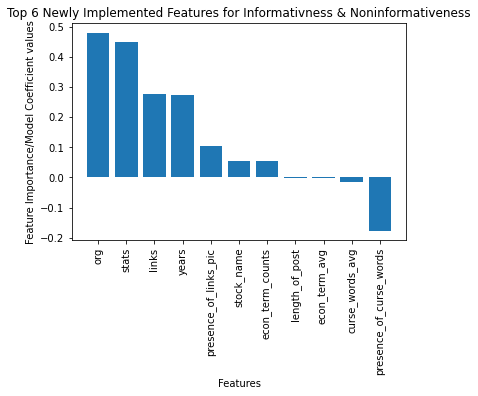

In [73]:
#graph and feature importance values (model coefficient values) of all features we ourselves implemented, which include all features other than the BOW features.
topnewfeats = plt.bar([x[0] for x in implementedtopfeatureweights], [x[1] for x in implementedtopfeatureweights])
plt.xticks(rotation = 90)
plt.xlabel("Features")
plt.ylabel("Feature Importance/Model Coefficient values")
plt.title("Top 6 Newly Implemented Features for Informativness & Noninformativeness")
for i in implementedtopfeatureweights:
  print(i[0], ": ", i[1])
  print()

Since the baseline model was a Logistic Regression BOW model while the improved model we developed was the baseline model with extra features that we implemented through feature engineering, we decided to analyze how well our implemented features did. The graph above shows the model coefficients of these features. It can be seen that the “org” and “stats” features performed considerably better than other features. This logically makes sense since informative posts about the economy or stock market tend to bring up the names of companies as well as facts/numbers about their performances. Likewise the feature we implemented that performed well in identifying posts to be uninformative was the “presence_of_curse_words” features. This makes sense because posts that use more curse words tend to be posts that insult others or rant/ramble on. On the other hand, it can be seen that features such as “length of post” and “econ term present avg” seemed to have feature importance values very close to 0. We decided to initially featurize the length of a post because posts that are packed with information tend to easily be identified as informative posts. We decided to also featurize the percentage of words in a post that are economic terms because informative reddit posts about the economy/stock market should intuitively use more economic/financial terms. After analyzing the mistakes the model made on the test data, we determined that the "length_of_post" feature was not an effective because shorter posts can be packed with useful information and longer posts can be packed with fluff and unrelated information. Moreover, we determined that our “econ_term_present_avg” feature performed poorly because many posts exist that use slang or basic language to explain important information about the stock market or economy.

Now below is a graph and a list of the top 6 features in our model that contributed towards informativeness, and the top 6 features that contributed twoards uninformativeness. These include features from the BOW model. 

org :  0.4793949915632445

stats :  0.44953560907070517

trading :  0.38657878331636863

: :  0.3543707988167438

oil :  0.32075611762100353

https :  0.311067703698142

i :  -0.3238797383443121

my :  -0.3220308926970006

still :  -0.2596025096524858

can :  -0.25957646768387355

what :  -0.23867454956853978

shit :  -0.21612483021627674



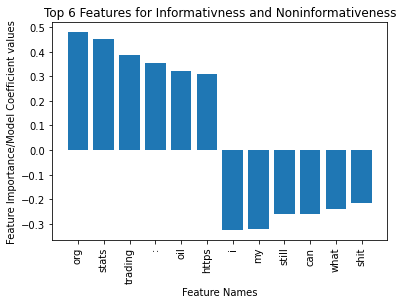

In [74]:
topfeats = plt.bar([x[0] for x in topfeatureweights], [x[1] for x in topfeatureweights], width = 0.8)
plt.xticks(rotation = 90)
plt.xlabel("Feature Names")
plt.ylabel("Feature Importance/Model Coefficient values")
plt.title("Top 6 Features for Informativness and Noninformativeness")
for i in topfeatureweights:
  print(i[0], ": ", i[1])
  print()

The graph above shows the top 6 best overall performing features for classifying posts as informative and top 6 best overall performing features for classifying posts as uninformative. For informative posts, it can be seen that the features we implemented, “org” and “stats” had the best performance. Intuitively this makes sense because posts that reference organizations or statistics/data tend to be informative about the economy or stock market. Features from the baseline BOW model also seem to have still performed very well with “I” being the best feature for determining if a post is uninformative. This may be because posts that use “I” and "my" a lot tend to be personal stories or rants that are not very informative about the economy or stock market.

An interesting feature to note is that "oil" was part of the 6 top performing features for determining if a post was informative. A logical reason for why "oil" is a higher performing feature is becuase the oil industry is one of the most influential industries in the economy/stock market and oil is so important that even countries fight over it. This shows that our model has been able to "learn" or identify mentions of oil as signs of the post being highly informative and highly relevant to the economy/stock market. 


## **Analyzing TP, TN, FP, FN, Precision, Recall, F-1 Score** 

In [75]:
testX, testY=load_data(testFile)

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [77]:
cm = confusion_matrix(predictions, testY)
con_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)

In [78]:
tn, fp, fn, tp = cm.ravel()

In [79]:
def scoring_function(tn, fp, fn, tp):
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f_score = (2 * precision * recall) / (precision + recall)
  return precision, recall, f_score

In [80]:
precision, recall, f_score = scoring_function(tn, fp, fn, tp)  

**Below is the Confusion Matrix of the Baseline Model**




Confusion Matrix of Baseline Model: 
True Positives: 43   True Negatives: 114
False Negatives: 15   False Positives: 28
Precision: 0.6056338028169014   Recall: 0.7413793103448276   F-1 Score: 0.6666666666666667


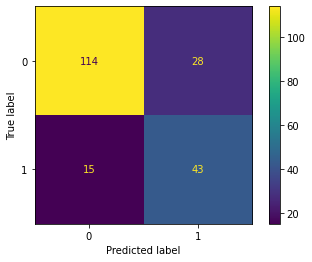

In [81]:
print("Confusion Matrix of Baseline Model: ")
basecm = confusion_matrix(base_predictions, testY)
base_con_matrix = ConfusionMatrixDisplay(confusion_matrix=basecm)
b_tn, b_fp, b_fn, b_tp = basecm.ravel()
b_precision, b_recall, b_f_score = scoring_function(b_tn, b_fp, b_fn, b_tp)  
base_con_matrix.plot()
print("True Positives: " + str(b_tp), " ", "True Negatives: " + str(b_tn))
print("False Negatives: " + str(b_fn), " ", "False Positives: " + str(b_fp))
print("Precision: " + str(b_precision)," ", "Recall: " + str(b_recall)," ","F-1 Score: " + str(b_f_score))

**Below is the Confusion Matrix of the Improved Model**

Confusion Matrix of Improved Model: 
True Positives: 47   True Negatives: 120
False Negatives: 9   False Positives: 24
Precision: 0.6619718309859155   Recall: 0.8392857142857143   F-1 Score: 0.7401574803149606


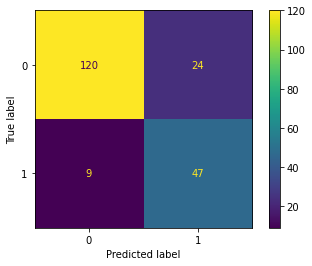

In [82]:
print("Confusion Matrix of Improved Model: ")
con_matrix.plot()
print("True Positives: " + str(tp), " ", "True Negatives: " + str(tn))
print("False Negatives: " + str(fn), " ", "False Positives: " + str(fp))
print("Precision: " + str(precision)," ", "Recall: " + str(recall)," ","F-1 Score: " + str(f_score))

Above are two Confusion matrices with the quantities of the True Positives, True Negatives, False Negatives, False Positives, Precision, Recall, and F-1 Score printed above. 

Taking a look at both matrices, tt can be seen from the matrix that there is indeed a class imbalance in our dataset. The test data set contains roughly 129 posts that are labeled as uninformative and 71 posts that are labeled as informative. Hence, there is roughly around 2x more uninformative posts than informative posts. As a result, the model has a better chance of finding trends and correlations in the uninformative posts than in the informative posts. Hence, this shows that the results of the model can be biased since its predictive accuracy for the uninformative posts will be lower than its predictive accuracy for the informative posts. 

Taking a look at the confusion matrix of the improved model, it can be seen that there are a lot more true positives and true negatives than false positives and false negatives. This is a good sign because it shows that our model has a relatively high accuracy in predicting both labels. Moreover, this shows that our model is able to relatively avoid commiting Type 1 and Type 2 errors. The precision of our model is around 0.66, which is above average, while the recall of our model is around 0.83, which is relatively high. Because it is less harmful to classify uninformative posts as informative posts than it is to classify informative posts as uninformative posts, we ideally want the number of false negatives to be lower than the number of false positives, which would make the recall higher than the precision. The confusion matrix and the recall being relatively higher than the precision shows that out model will tend to produce less false negatives than false positives.

The f1 score is the harmonic mean of the precision and recall of our results. This score is a very useful metric for classification model, especially for situations where there is an uneven balance of labels. The f1 score of our improved model was 0.74, which is relatively high and shows that the model overall performs well for accurately predicting informative and uninformative posts. 

Comparing the confusion matrix of the baseline model and the confusion matrix of the improved model, we can see that the improved model is better on all fronts. the Improved model has more true positives and true negatives while having less false positives and false negatives than the baseline model. The improved model also has a higher precision, recall, and f1 score than the baseline model. This shows that the new features we implemented caused the model to drastically increase its ability to correctly label the reddit posts. 





## **Analyzing Systematic Mistakes in False Negative Posts**

In [83]:
false_neg_cases = []
false_pos_cases = []
for i in range(len(testX)):
  if testY[i] != predictions[i]:
    if testY[i] == '1':
      false_neg_cases.append(testX[i])
    else:
      false_pos_cases.append(testX[i])

In [84]:
false_neg_cases

["Oracle is responsible for all of the bank-to-bank transactions for the Ruble in Russia on Oracle Database, and there is no alternative solution to their services in the Russian market. If Oracle were to leave Russia, it would prevent all Russian businesses from being able to deal with one another. Oracle has enough soft power in order to end the war in Ukraine in a single day, and as fellow Redditors I ask you whether or not you can ethnically support a company who refuses to stand by and do nothing while Ukraine suffers.  It's time to put your money where your mouth is.\n",
 "The exact message from Schwab:   “Important Notifications: Important Update Regarding Trading Russian Securities: Due to liquidity issues stemming from restrictions placed on all Russian securities (not just those impacted by recent sanctions) by Schwab's clearing agents, neither buy nor sell orders on Russian securities are able to be accepted at this time. This is a rapidly evolving situation and we will cont

Above is a list of posts that were false negatives after running the model on the test data. After analayzing these posts, we determined a couple of categories of common mistakes that the model made when classifying these posts. 

**1. Presence of curse words as signs of insulting or threatening language**
* Example Post: "Alright, retard, all opinions on memestocks and AMC squeeze shenanigans out the window for this post and comment section.🤝  We will focus on this AMC gold miner deformed dumpster baby that literally gets sketchier the deeper you really look.  But first, how greasy is this deal? [Greasy](https://www.youtube.com/watch?v=S7FsAgPuVwU)  Let us dive in:  1st: Let me take this layup real quick, movie theatre executives don't know dick on how to fucking mine for natural precious metals. Coincidentally, this is about as close as a YOLO a corporate executive/board can go.  2nd: HYMC coincidentally drops an ATM stock offering this morning of up to 500 million unloading on apes as the stocks price launches. For those who don't understand, they are essentially able to soak up this 500% share price increase in taking a shitload of cash while massively diluting their shares. Isn't it odd that this was left out of the AMC press release and not spoken about at all on MSM today? Personally, I read an article in Barrons and NYT that completely failed to even mention it once. Side note: in a total dipshit move that makes Cramer look normal aaron [canceled](https://twitter.com/CEOAdam/status/1503763167473713155?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Etweet) …”
* Many uninformative posts are posts that complain about the economy/stock market or make fun of others for their invests. Such posts tend to use curse words to insult or make fun of others. This post uses a lot of curse words (like "retard") but does not use them to make excessive fun of or insult others. In fact, the post is informative because it brings up a valuable argument that is supported with logic, evidence, and links. Because of the amount of curse words there were in the post, the model seemed to have classified the post as uninformative. 

**2. Uncommon Acronyms for organizations**
* Example Post: 'FB crashing 23% may be an overreaction but it is happing across the market. Pinterest and Spotify crashing at earnings as well. Market is pricing in a bear market for rate hikes. I think the goal should be to slightly average in over the next few months but more so save cash as things may get worse.\n'
* The post above references the company Facebook as FB. Although the model checks for the presence of important companies like Facebook, it is unfamiliar with many of the informal acronyms that people use for such companies. This can cause the "org" feature to not work as well as intended, which can highly likeley result in the model misclassifying informaative some posts as uninformative.

**3. References to events that indirectly affect the economy or stock market** 
* Example Post: 'I wrote [this](https://www.reddit.com/r/wallstreetbets/comments/sswuta/its_not_if_but_how_much/) post last night that started a nice discussion, and thought I would try to keep the conversation going.   It seems like Vladimir Putin has decided to reopen negotiations with West. After posturing over 100,000 troops along the Ukrainian border, AP reported that his military has started to pull back some of its forces. So is diplomacy in play?  While my analysis looks wrong so far, I did get one aspect correct. Putin was at a standstill and had to make a move, or risk diminishing his bargaining power. I thought Putin would take the opportunity to use aggression and force Zelensky’s hand to ultimately reject NATO. He used it to open negotiations on his terms.   I recognize that no one wants to go to war. They are expensive and often lead to unintended consequences. But Putin’s posturing shift seems to signal something else. If diplomacy is on the table, why not start with that? It could have been a miscalculation, with Putin assuming the Ukrainian comedian would quickly submit. But at the end of the day, Russia wants Ukraine independent from NATO and Ukraine wants to remain in NATO. Both of these realities cannot be true. Putin has to either admit defeat in negotiations, or invade Ukraine.   Negotiations will begin quickly, if they occur. We will know if Putin plans to keep his word within the next few days. I’m think we’ll hear about a false flag attack in Belarus before that. The markets will react negatively.   Positions: SPY puts\n'
* The post references the war between Ukraine and Russia. Even though the post does not contain much economic terms, it references events related to a war that have enormous impacts on the economy or stock market. Because the features of the model highly focus/prioritize using statistics or economic terminology as signs of informativeness, the model mistakenly categorizes posts like this as uninformative. 




## **Analyzing Systematic Mistakes in False Positive Cases**




In [85]:
false_pos_cases

['Let me say up front I am a Contrarian.  When people are buying I am slowly selling and vice versa.  Been doing it a long time and if you have patience it works.  3 and 4  years ago I was loading up on Energy (VDE, CVX, XON, PSX mainly).  And a little 100 year old company that makes wheels and under carriages for big equipment -- **TWI**.  Probably 65% out of then now.  What do I think is the next good way to make money with a little patience?  https://preview.redd.it/igjx3vfvyii81.png?width=582&amp;format=png&amp;auto=webp&amp;s=69d825d504fa061db35428d30f758fb4013bcafc  **ARKF, ARKW, and ARK in equal amount**s -- buy some every 3 months until tech turns around.  **Cruise ships** also.  And **hotel ETFs** such as INN (get it in the $10 range).  We seem to be on the down side of COVID and cruise ships have yet to really take off.  Buy all 3, as one may go bankrupt -- not sure which one.  And then when these recover, sell and go back into energy and tobacco and wait again.  ***And Best 

Above is a list of posts that were false negatives after running the model on the test data. After analayzing these posts, we determined a couple of categories of common mistakes that the model made when classifying these posts. 

**1. Randomly mentioning economic entities such as organizations and statistics without explaining their significance to the economy or stock market.**
 

**2.Making opinionated statements that can be false or have not been logically supported. Posts contain personal stories or rants rather than relevant information about the economy or stock market**

**Example Post:** 'Let me say up front I am a Contrarian. When people are buying I am slowly selling and vice versa. Been doing it a long time and if you have patience it works. 3 and 4 years ago I was loading up on Energy (VDE, CVX, XON, PSX mainly). And a little 100 year old company that makes wheels and under carriages for big equipment -- TWI. Probably 65% out of then now. What do I think is the next good way to make money with a little patience? https://preview.redd.it/igjx3vfvyii81.png?width=582&format=png&auto=webp&s=69d825d504fa061db35428d30f758fb4013bcafc ARKF, ARKW, and ARK in equal amounts -- buy some every 3 months until tech turns around. Cruise ships also. And hotel ETFs such as INN (get it in the $10 range). We seem to be on the down side of COVID and cruise ships have yet to really take off. Buy all 3, as one may go bankrupt -- not sure which one. And then when these recover, sell and go back into energy and tobacco and wait again. And Best of Luck!\n',

The post above mentions the names of companies but does not talk about their signficance to the economy or the stock market. Moreeover, the post does not include any logical arguments. The author mentions to take action on stocks with no explanation as for why. Since the model checks for the presence of economic terminology, this could be why the model misclassifies these posts as informative. 

## **Future Ideas for Model Improvement**

1. Transitioning to using more complex models can be a great way of improving the accuracy/precision of the model. BERT can be a great model to use since it is aware of context and uses "self attention"

2. Using sentiment analysis to determine the intent of a post. Since uninformative posts on reddit tend to very heavily criticize or insult others, we implemented a feature called "curse_word_avg" that computes the percentage of a text containing curse words but discovered that the feature did not perform as well as intended. Using sentiment analysis would be a better way of accomplishing this task. 

3. Performing an in depth Exploratory Data Analysis where we take a look at our data and discover trends in the data can be a great way of improving our existing model. The EDA can help us better the feature engineering process and discover new features that can help improve the performance of the model. Conducting a Principal Component Analysis can also help us identify the importance of each feature and determine which features should ultimately be used in the model. 

4. Tuning hyperparameters by using K-fold cross validation can improve the performance of the model. 

5. Improving the unigram bag of words implementation by using bigrams can make our features more comprehensive and hence improve the model.

6. Using training data over the span of a couple years can greatly improve the performance of the model. Because the training data only consists of reddit posts from this year, the information in the posts could be skewed. Using training data from the span of a couple years can make the training data more diverse and help the model discover new trends. 
